In [11]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
import matplotlib.pyplot as plt

In [ ]:
# INRIX
# Speed — The current estimated harmonic mean speed for the roadway segment in miles per hour.
# Historical Average Speed — The historical average speed for the roadway segment for that hour of the day and day of the week in miles per hour.
# Reference Speed — The calculated "free flow" mean speed for the roadway segment in miles per hour. This attribute is calculated based upon the 66th-percentile point of the observed speeds on that segment for all time periods, which establishes a reliable proxy for the speed of traffic at free-flow for that segment.
# Travel Time — Time it will take to drive along the roadway segment (Distance Traveled / Speed).
# Confidence score — This is a simple confidence factor.
# 30 — high confidence, based on real-time data for that specific segment
# 20 — medium confidence, based on real-time data across multiple segments and/or based on a combination of expected and real-time data
# 10 — lower confidence, based primarily on historical data or road reference speeds
# C-Value — Indicates the probability that the current probe reading represents the actual roadway conditions based on recent and historical trends. This value is only used when the confidence score is 30. (0 = low probability, 100 = high probability)

# Metadata fields
# These fields are associated with each segment:datasource - the data set this record comes from. This field is only included in Massive Data Downloader exports when choosing to merge the data sets into a single CSV file.
# tmc - the unique 9-digit value identifying the segment.
# road - the route number or common name of the roadway
# direction - the overall direction of the roadway
# intersection - the cross street and/or interchange associated with the segment
# state - the postal abbreviation of the state to which the segment is assigned
# miles - the length of the segment
# road_order - a numerical value indicating in what order the segment would be encountered when traveling downstream relative to the other segments on the same road
# start_latitude - the latitude of the beginning of

# Venue polygon and shuttle points

In [4]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

,geometry,name
0,"POLYGON ((-97.64739 30.13196, -97.63569 30.14634, -97.61965 30.14039, -97.63147 30.12263, -97.64739 30.13196))",the Circuit of the Americas


In [5]:
import shapely.geometry as geom

# Create Shapely point geometries
point_waterloo_park = geom.Point(-97.736285, 30.273726) # (longitude, latitude)
point_barton_creek_square = geom.Point(-97.805046, 30.257509)
point_expo_center = geom.Point(-97.622544, 30.297062)
point_ridehailing = geom.Point(-97.614135, 30.178718)

point_shuttle_list = [point_waterloo_park,point_barton_creek_square,point_expo_center,point_ridehailing]
gdf_shuttle = gpd.GeoDataFrame({'Shuttle_Location': ['Shuttle_Waterloo_Park', 'Shuttle_Barton_Creek_Square', 'Shuttle_Expo_Center', 'Uber_DelValle_HighSchool'],
                        'geometry': point_shuttle_list},
                        crs="EPSG:4326")
gdf_shuttle

,Shuttle_Location,geometry
0,Shuttle_Waterloo_Park,POINT (-97.73628 30.27373)
1,Shuttle_Barton_Creek_Square,POINT (-97.80505 30.25751)
2,Shuttle_Expo_Center,POINT (-97.62254 30.29706)
3,Uber_DelValle_HighSchool,POINT (-97.61414 30.17872)


# Downsamping Austin INRIX traffic volume data (I run this on my laptop)
takes 5min ish (only need to run once)

# Load road network information

In [12]:
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
# print(df_road.type.unique())
# print(sorted(df_road.road_order.unique()))
df_road.head(2)

,tmc_code,road,direction,intersection,state,county,zip,start_latitude,start_longitude,end_latitude,end_longitude,miles,road_order,timezone_name,type,country,active_start_date,active_end_date
0,112P13033,GUADALUPE ST,NORTHBOUND,W MARTIN LUTHER KING JR BLVD,TX,TRAVIS,78705,30.28172,-97.74193,30.28232,-97.74207,0.04249,1.00000,America/Chicago,P1.11,USA,2022-03-22 14:00:00-04:00,2023-03-21 14:00:00-04:00
1,112+08908,TX-21,EASTBOUND,FM-20,TX,BASTROP,78602,30.11066,-97.41049,30.11082,-97.37323,2.22783,21.00000,America/Chicago,P1.11,USA,2022-03-22 14:00:00-04:00,2023-03-21 14:00:00-04:00


In [13]:
print(df_road.columns)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']] #,'road_order'
df_road.head(3)

Index(['tmc_code', 'road', 'direction', 'intersection', 'state', 'county', 'zip', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'road_order', 'timezone_name', 'type', 'country', 'active_start_date', 'active_end_date'], dtype='object')


,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249
1,112+08908,FM-20,30.11066,-97.41049,30.11082,-97.37323,2.22783
2,112+16538,GATTIS SCHOOL RD,30.49057,-97.67514,30.49351,-97.67573,0.20831


In [14]:
# !pip install folium matplotlib mapclassify

In [15]:
%%time
from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")

CPU times: user 147 ms, sys: 23.1 ms, total: 170 ms
Wall time: 538 ms


The data only contain major or primary road segments, might not observe minor roads

In [27]:
# # show all the road segments in Austin
# gdf_road.explore(
#     legend=False
# )

# Load traffic data

In [16]:
%%time
df_traffic = pd.read_csv("data/austin_202210_10min_interval.csv", sep=',', header=0)
print(df_traffic.shape[0])
df_traffic['Date'] = df_traffic['measurement_tstamp'].astype(str).str[0:10]
df_traffic['Date'] = pd.to_datetime(df_traffic['Date'], errors='coerce')
print(df_traffic['Date'].unique())

# start_date, end_date = '2022-10-14','2022-10-16'
# df_traffic_oneweekbefore = df_traffic[(df_traffic['Date']>=start_date)&(df_traffic['Date']<=end_date)]
df_traffic.head(5)
# Speed — The current estimated harmonic mean speed for the roadway segment in miles per hour.
# Historical Average Speed — The historical average speed for the roadway segment for that hour of the day and day of the week in miles per hour.
# Reference Speed — The calculated "free flow" mean speed for the roadway segment in miles per hour. This attribute is calculated based upon the 66th-percentile point of the observed speeds on that segment for all time periods, which establishes a reliable proxy for the speed of traffic at free-flow for that segment.
# Travel Time — Time it will take to drive along the roadway segment (Distance Traveled / Speed).

8974972
['2022-10-10T00:00:00.000000000' '2022-10-11T00:00:00.000000000'
 '2022-10-12T00:00:00.000000000' '2022-10-13T00:00:00.000000000'
 '2022-10-14T00:00:00.000000000' '2022-10-15T00:00:00.000000000'
 '2022-10-16T00:00:00.000000000' '2022-10-17T00:00:00.000000000'
 '2022-10-18T00:00:00.000000000' '2022-10-19T00:00:00.000000000'
 '2022-10-20T00:00:00.000000000' '2022-10-21T00:00:00.000000000'
 '2022-10-22T00:00:00.000000000' '2022-10-23T00:00:00.000000000']
CPU times: user 7.49 s, sys: 1.09 s, total: 8.58 s
Wall time: 9.58 s


,tmc_code,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue,Inrix 2013,Inrix 2019,Date
0,112P13033,2022-10-10 00:00:00,21.00000,17.00000,17.00000,0.09000,30.00000,100.00000,2.00000,2.00000,2022-10-10
1,112P13033,2022-10-10 00:10:00,27.00000,17.00000,17.00000,0.07000,30.00000,100.00000,2.00000,2.00000,2022-10-10
2,112P13033,2022-10-10 00:20:00,27.00000,17.00000,17.00000,0.07000,30.00000,90.00000,2.00000,2.00000,2022-10-10
3,112P13033,2022-10-10 00:30:00,16.00000,17.00000,17.00000,0.12000,30.00000,100.00000,2.00000,2.00000,2022-10-10
4,112P13033,2022-10-10 00:40:00,17.00000,17.00000,17.00000,0.12000,30.00000,100.00000,2.00000,2.00000,2022-10-10


In [18]:
# # Plot overlaid histograms
# plt.hist(df_traffic['historical_average_speed'], bins=30, alpha=0.5, label='Historical Average Speed')
# plt.hist(df_traffic['reference_speed'], bins=30, alpha=0.5, label='Reference Speed')
# plt.legend()

In [19]:
%%time
df_traffic_merged = df_traffic.merge(df_road) #, left_on='tmc_code', right_on='tmc'
df_traffic_merged['travel_time_sec'] = df_traffic_merged['miles']/df_traffic_merged['speed']*3600
df_traffic_merged['measurement_tstamp'] = pd.to_datetime(df_traffic_merged['measurement_tstamp'])
df_traffic_merged['hour_min'] = df_traffic_merged['measurement_tstamp'].dt.strftime('%H:%M')
df_traffic_merged['delay'] = df_traffic_merged['travel_time_sec'] - df_traffic_merged['miles']/df_traffic_merged['reference_speed']*3600

CPU times: user 32.7 s, sys: 3.14 s, total: 35.8 s
Wall time: 33.2 s


## (Optional) Visualizing traffic delay compare to historic average free flow

In [123]:
df_traffic_merged.loc[df_traffic_merged.delay <= 10, 'delay_level'] = 0
df_traffic_merged.loc[(df_traffic_merged.delay > 10)&(df_traffic_merged.delay <= 30), 'delay_level'] = 1
df_traffic_merged.loc[(df_traffic_merged.delay > 30)&(df_traffic_merged.delay <= 60), 'delay_level'] = 2
df_traffic_merged.loc[(df_traffic_merged.delay > 60)&(df_traffic_merged.delay <= 120), 'delay_level'] = 3
df_traffic_merged.loc[(df_traffic_merged.delay > 120)&(df_traffic_merged.delay <= 300), 'delay_level'] = 4
df_traffic_merged.loc[df_traffic_merged.delay > 300, 'delay_level'] = 5
df_traffic_merged.delay_level.value_counts()

# Very Low Congestion: delay <= 10 seconds
# Low Congestion: 10 < delay <= 30 seconds
# Moderate Congestion: 30 < delay <= 60 seconds
# High Congestion: 60 < delay <= 120 seconds
# Very High Congestion: 120 < delay <= 300 seconds
# Severe Congestion: delay > 300 seconds

0.00000    3507244
1.00000    256495 
2.00000    57554  
3.00000    17544  
4.00000    5854   
5.00000    1343   
Name: delay_level, dtype: int64

In [124]:
gdf_road_merged = gdf_road.merge(df_traffic_merged[['tmc_code','Date','hour_min','delay','delay_level']]) #, left_on='tmc', right_on='tmc_code'
gdf_road_merged['Date'] = gdf_road_merged['Date'].astype(str)
print(gdf_road_merged.shape[0])
gdf_road_merged.head()

3846034


,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry,Date,hour_min,delay,delay_level
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-21,00:00,-1.71368,0.00000
1,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-21,00:10,-3.33216,0.00000
2,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-21,00:20,-3.72282,0.00000
3,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-21,00:30,0.56230,0.00000
4,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",2022-10-21,00:40,-2.04473,0.00000


In [25]:
# gdf_road_merged.to_csv('output/austin_2022_GP_10min_interval_withDelay_geodf.csv',index=False)

In [32]:
%%time

select_vis_date, select_hour_min = '2022-10-23', '20:00'
# gdf_road_merged.delay_level.value_counts()

congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]

m = gdf_road_merged[(gdf_road_merged['Date']==select_vis_date)&(gdf_road_merged['hour_min']==select_hour_min)].explore(
    column='delay_level',
    cmap= congestion_colors, #"rainbow",
    tiles="CartoDB Positron", # OpenStreetMap, CartoDB dark_matter, CartoDB Positron
    categorical=True
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

polygon.explore(
    m=m
)

## Compute delay difference using the baseline as the same day from the last week
Using Saturdays as an example

In [39]:
%%time

df_diff_all = pd.DataFrame()

for day_pair in [['2022-10-10','2022-10-17'],['2022-10-11','2022-10-18'],['2022-10-12','2022-10-19'],['2022-10-13','2022-10-20'],
                 ['2022-10-14','2022-10-21'],['2022-10-15','2022-10-22'],['2022-10-16','2022-10-23']]:
    day1, day2 = day_pair[0],day_pair[1]
    print(day1, day2)
    
    df_baseline = df_traffic_merged[df_traffic_merged['Date']==day1].sort_values(by=['tmc_code','measurement_tstamp'], ascending=True)
    
    df_focus = df_traffic_merged[df_traffic_merged['Date']==day2].sort_values(by=['tmc_code','measurement_tstamp'], ascending=True)
    
    print(df_baseline.shape[0], df_focus.shape[0])

    df_diff = pd.merge(
        df_baseline[['tmc_code', 'hour_min','delay']],
        df_focus[['tmc_code','hour_min', 'delay']],
        on=['tmc_code','hour_min'],
        suffixes=('_baseline', '_focus')
    )
    
    # Calculate the delay difference
    df_diff['delay_difference'] = df_diff['delay_focus'] - df_diff['delay_baseline']
    
    df_diff['date'] = day2

    df_diff_all = pd.concat([df_diff_all, df_diff], ignore_index=True)

2022-10-10 2022-10-17
641070 641081
2022-10-11 2022-10-18
641140 641142
2022-10-12 2022-10-19
641145 641146
2022-10-13 2022-10-20
641062 641152
2022-10-14 2022-10-21
640864 641152
2022-10-15 2022-10-22
640856 641152
2022-10-16 2022-10-23
640858 641152
CPU times: user 4.87 s, sys: 23.5 ms, total: 4.9 s
Wall time: 4.88 s


In [40]:
print(df_diff_all.shape[0])
df_diff_all = df_diff_all[~((df_diff_all['date']=='2022-10-17')&(df_diff_all['hour_min']=='06:01'))]
print(df_diff_all.shape[0])

4468774
4468772


In [41]:
%%time
df_diff_all.to_csv('output/austin_2022_GP_10min_interval_delaydifference.csv',index=False)
df_diff_all.date.value_counts()

CPU times: user 17.2 s, sys: 474 ms, total: 17.6 s
Wall time: 18.9 s


2022-10-18    641080
2022-10-17    641014
2022-10-21    640800
2022-10-22    640800
2022-10-20    636546
2022-10-23    636350
2022-10-19    632182
Name: date, dtype: int64

In [42]:
df_diff_all.head(2)

,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,date
0,112+04758,00:00,-1.08205,1.61527,2.69732,2022-10-17
1,112+04758,00:10,-1.53414,-0.83576,0.69838,2022-10-17


## (Optional) Visualizing delay difference

In [128]:
gdf_road_merged_delaydiff = gdf_road.merge(df_diff_all[['tmc_code','hour_min','date','delay_difference']]) 
print(gdf_road_merged_delaydiff.shape[0]) #11498800
gdf_road_merged_delaydiff.head(2)

1917950


,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles,geometry,hour_min,date,delay_difference
0,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",00:00,2022-10-21,-0.76665
1,112P13033,W MARTIN LUTHER KING JR BLVD,30.28172,-97.74193,30.28232,-97.74207,0.04249,"LINESTRING (-97.74193 30.28172, -97.74207 30.28232)",00:10,2022-10-21,0.00000


In [31]:
%%time

select_vis_date, select_hour_min = '2022-10-22', '20:00'
# congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]

m = gdf_road_merged_delaydiff[(gdf_road_merged_delaydiff['date']==select_vis_date)&(gdf_road_merged_delaydiff['hour_min']==select_hour_min)].explore(
    column='delay_difference',
    cmap= 'rainbow', #"rainbow",
    tiles="CartoDB Positron", # OpenStreetMap, CartoDB dark_matter, CartoDB Positron
    categorical=False
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

polygon.explore(
    m=m
)

## Plot average delay time for the whole Austin network and compare with the average delay from the same day last week

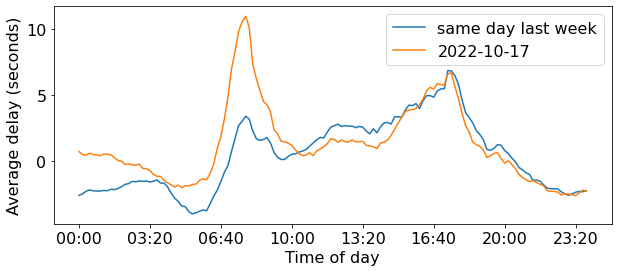

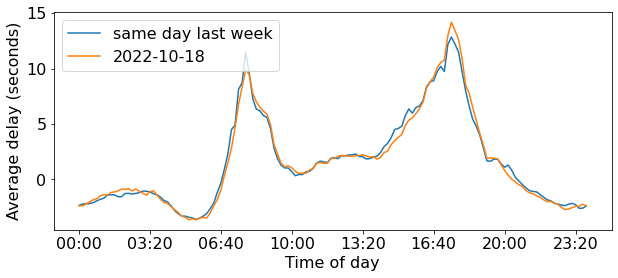

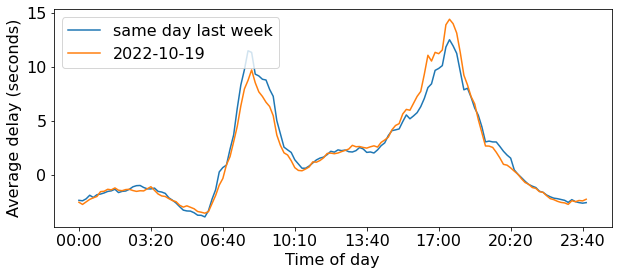

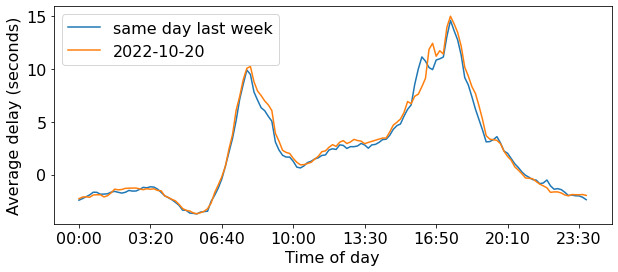

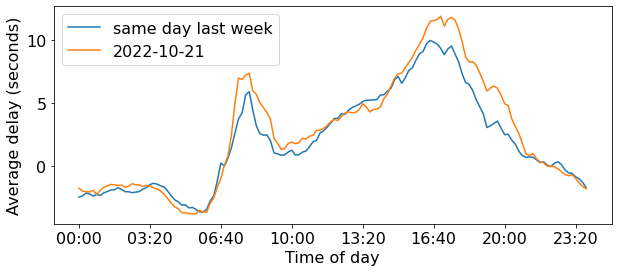

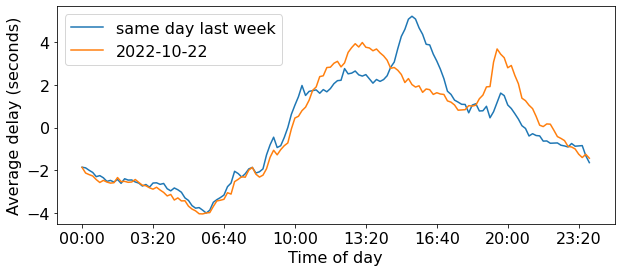

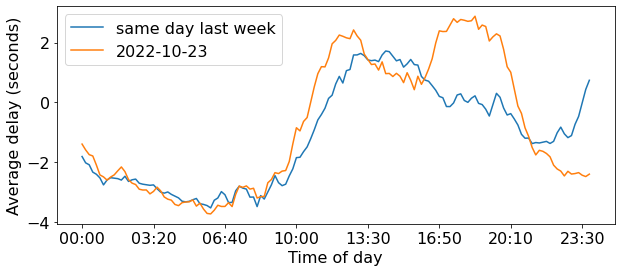

In [44]:
def plot_delay_baseline(df,date):
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, figsize=(10, 4))
    df_select = df[df['date']==date]
    df_select.groupby('hour_min').delay_baseline.mean().plot(ax=ax,label='same day last week')
    df_select.groupby('hour_min').delay_focus.mean().plot(ax=ax,label=date)
    plt.xticks(rotation=0)
#     plt.title(date)
    ax.set_ylabel('Average delay (seconds)')
    ax.set_xlabel('Time of day')
    plt.legend()
    plt.show()


plot_delay_baseline(df_diff_all,'2022-10-17')
plot_delay_baseline(df_diff_all,'2022-10-18')
plot_delay_baseline(df_diff_all,'2022-10-19')
plot_delay_baseline(df_diff_all,'2022-10-20')

plot_delay_baseline(df_diff_all,'2022-10-21')
plot_delay_baseline(df_diff_all,'2022-10-22')
plot_delay_baseline(df_diff_all,'2022-10-23')

## Average delay difference for the whole network (current day delay - last week same day delay)

count   640800.00000
mean    0.01817     
std     13.89503    
min     -718.04016  
25%     -1.68958    
50%     0.00000     
75%     1.67957     
max     1010.46066  
Name: delay_difference, dtype: float64


<Axes: >

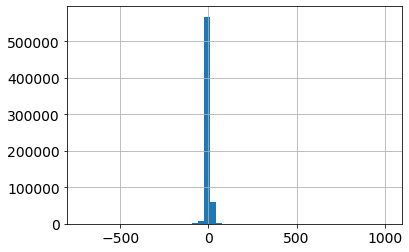

In [131]:
selectOneDate = '2022-10-22' # Saturday
df_diff_select = df_diff_all[df_diff_all['date']==selectOneDate]
plt.rcParams.update({'font.size': 14})
print(df_diff_select.delay_difference.describe())
df_diff_select.delay_difference.hist(bins=50)

In [45]:
import matplotlib.dates as mdates


def plot_delay_diff_oneday(df, date):
    
    plt.rcParams.update({'font.size': 14})
    
    df_diff_select = df[df['date']==date]

    df_diff_new = df_diff_select.groupby('hour_min').delay_difference.mean().reset_index()

    df_diff_new['hour_min'] = pd.to_datetime(df_diff_new['hour_min'], format='%H:%M')

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the time series
    ax.plot(df_diff_new['hour_min'], df_diff_new['delay_difference'],label='Average Delay Difference')

    # Formatting the x-axis to show hours and minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Adjust interval as needed

    plt.xticks(rotation=90)
    plt.title(date)
    plt.xlabel('Time of day')
    plt.ylabel('Average difference in delay (seconds)')
    plt.axhline(y=0, color='r', linestyle='--')
    # plt.legend()
#     plt.grid()
    plt.tight_layout()
    plt.show()

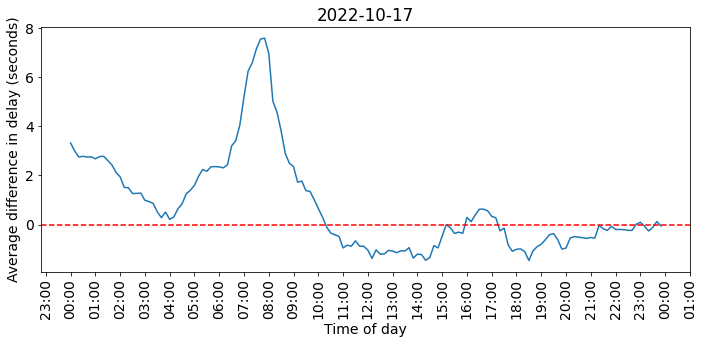

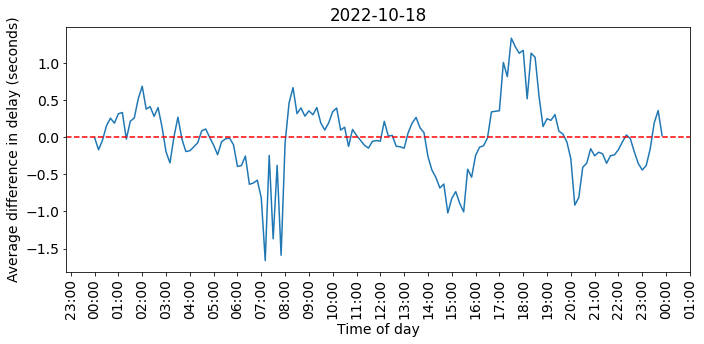

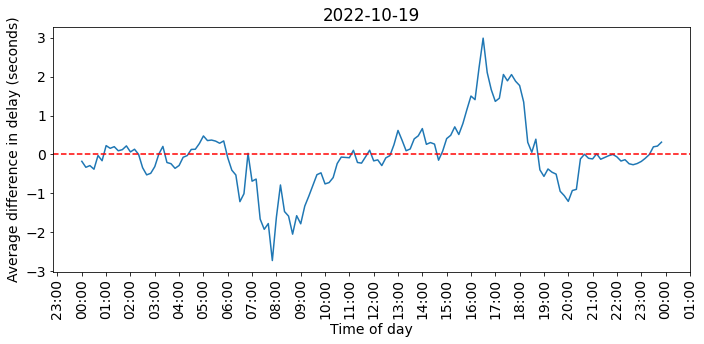

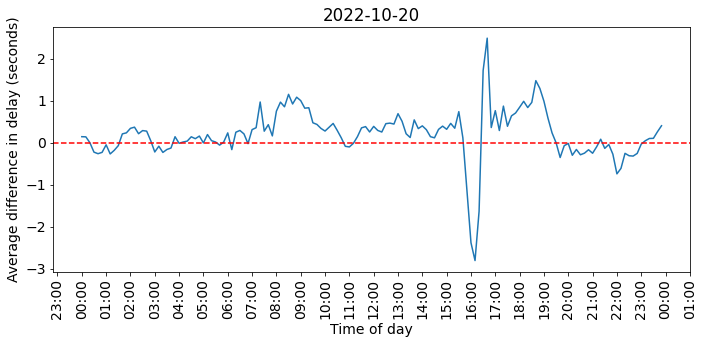

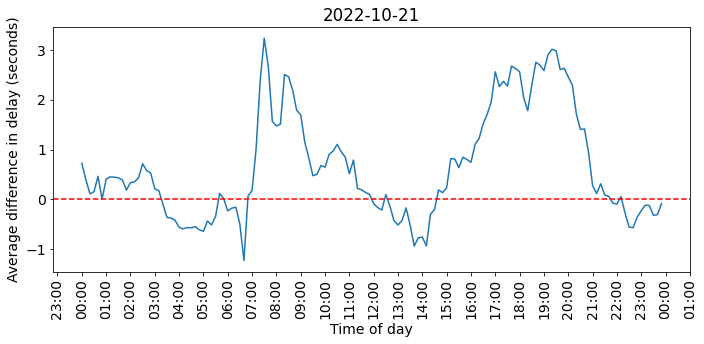

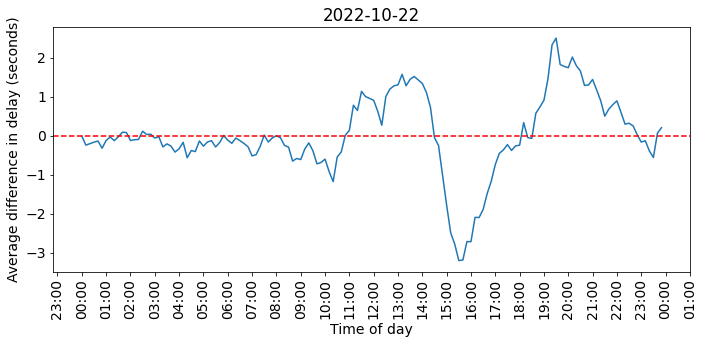

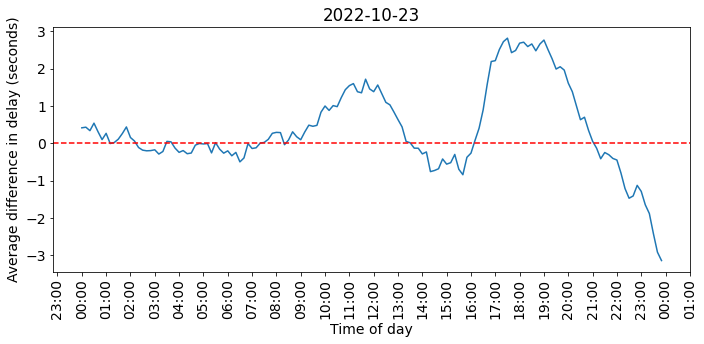

In [46]:
plot_delay_diff_oneday(df_diff_all, '2022-10-17') 
plot_delay_diff_oneday(df_diff_all, '2022-10-18') 
plot_delay_diff_oneday(df_diff_all, '2022-10-19')
plot_delay_diff_oneday(df_diff_all, '2022-10-20') 
plot_delay_diff_oneday(df_diff_all, '2022-10-21') # Friday 
plot_delay_diff_oneday(df_diff_all, '2022-10-22') # Saturday 
plot_delay_diff_oneday(df_diff_all, '2022-10-23') # Sunday 

In [134]:
df_diff_all.head()

,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,date
0,112+04758,00:00,-1.08205,-0.57432,0.50773,2022-10-21
1,112+04758,00:10,-0.57432,-0.96072,-0.38640,2022-10-21
2,112+04758,00:20,-0.29628,-0.83576,-0.53949,2022-10-21
3,112+04758,00:30,-0.57432,-0.83576,-0.26144,2022-10-21
4,112+04758,00:40,-0.83576,-0.83576,0.00000,2022-10-21
